# CNN

卷积神经网络包括卷积层和池化层。卷积层的核心是二维互相关（cross-correlation）运算，它的输入是一个二维输入数组和一个二维核（kernel）数组，输出也是一个二维数组，其中核数组通常称为卷积核或过滤器（filter）。卷积核的尺寸通常小于输入数组，卷积核在输入数组上滑动，在每个位置上，卷积核与该位置处的输入子数组按元素相乘并求和，得到输出数组中相应位置的元素。


In [53]:
# 一个简单的实现二维互相关运算的例子
import torch 
import torch.nn as nn

def corr2d(X, K):
    H, W = X.shape
    h, w = K.shape
    Y = torch.zeros(H - h + 1, W - w + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 1], [2, 3]])
Y = corr2d(X, K)
print(Y)

tensor([[19., 25.],
        [37., 43.]])


In [54]:
X = torch.tensor([[0, 1, 2,3], [3, 4, 5,6], [6, 7, 8,9],[9,10,11,12]])
K = torch.tensor([[0, 1], [2, 3]])
Y = corr2d(X, K)
print(Y,X.shape,K.shape,Y.shape)

tensor([[19., 25., 31.],
        [37., 43., 49.],
        [55., 61., 67.]]) torch.Size([4, 4]) torch.Size([2, 2]) torch.Size([3, 3])


二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏置来得到输出。卷积层的模型参数包括卷积核和标量偏置。

In [55]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias
        #bias参数个数为1,基于广播机制做的加法

下面我们看一个例子，我们构造一张$6 \times 8$的图像，中间4列为黑（0），其余为白（1），希望检测到颜色边缘。我们的标签是一个$6 \times 7$的二维数组，第2列是1（从1到0的边缘），第6列是-1（从0到1的边缘）。


In [64]:
X = torch.ones(6, 8)
Y = torch.zeros(6, 7)
X[:, 2: 6] = 0
Y[:, 1] = 1
Y[:, 5] = -1
print(X) # X作为输入
print(Y) # Y作为标签

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


我们希望学习一个$1 \times 2$卷积层，通过卷积层来检测颜色边缘。


In [65]:
conv2d = Conv2D(kernel_size=(1, 2))
step = 50
lr = 0.01
for i in range(step):
    Y_hat = conv2d(X)
    l = ((Y_hat - Y) ** 2).sum()# 损失值
    l.backward() #反向传播
    # 使用梯度下降
    conv2d.weight.data -= lr * conv2d.weight.grad
    conv2d.bias.data -= lr * conv2d.bias.grad
    
    # 梯度清零
    conv2d.weight.grad.zero_()
    conv2d.bias.grad.zero_()
    if (i + 1) % 5 == 0:
        print('Step %d, loss %.3f' % (i + 1, l.item()))
        
print(conv2d.weight.data)
print(conv2d.bias.data)

Step 5, loss 2.373
Step 10, loss 0.574
Step 15, loss 0.150
Step 20, loss 0.041
Step 25, loss 0.011
Step 30, loss 0.003
Step 35, loss 0.001
Step 40, loss 0.000
Step 45, loss 0.000
Step 50, loss 0.000
tensor([[ 1.0011, -1.0011]])
tensor([-5.9105e-06])


In [66]:
Y_hat.shape #计算方法与上边相同.

torch.Size([6, 7])

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


conv2d = Conv2D(kernel_size=(1, 2))
step = 30
lr = 0.01
for i in range(step):
    Y_hat = conv2d(X)
    l = ((Y_hat - Y) ** 2).sum()# 损失值
    l.backward() #反向传播
    # 使用梯度下降
    # onv2d.weight -= lr * conv2d.weight.grad # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    conv2d.weight = conv2d.weight - lr * conv2d.weight.grad 
    # TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected) ???
    #conv2d.bias -= lr * conv2d.bias.grad
    conv2d.bias = conv2d.bias - lr * conv2d.bias.grad
    
    # 梯度清零
    conv2d.weight.grad.zero_()
    conv2d.bias.grad.zero_()
    if (i + 1) % 5 == 0:
        print('Step %d, loss %.3f' % (i + 1, l.item()))
        
print(conv2d.weight.data)
print(conv2d.bias.data)

TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

### 互相关运算与卷积运算

卷积层得名于卷积运算，但卷积层中用到的并非卷积运算而是互相关运算。我们将核数组上下翻转、左右翻转，再与输入数组做互相关运算，这一过程就是卷积运算。
由于卷积层的核数组是可学习的，所以使用互相关运算与使用卷积运算并无本质区别。

### 特征图与感受野

二维卷积层输出的二维数组可以看作是输入在空间维度（宽和高）上某一级的表征，也叫特征图（feature map）。影响元素$x$的前向计算的所有可能输入区域（可能大于输入的实际尺寸）叫做$x$的感受野（receptive field）。

以图1为例，输入中阴影部分的四个元素是输出中阴影部分元素的感受野。我们将图中形状为$2 \times 2$的输出记为$Y$，将$Y$与另一个形状为$2 \times 2$的核数组做互相关运算，输出单个元素$z$。那么，$z$在$Y$上的感受野包括$Y$的全部四个元素，在输入上的感受野包括其中全部9个元素。可见，我们可以通过更深的卷积神经网络使特征图中单个元素的感受野变得更加广阔，从而捕捉输入上更大尺寸的特征。

## 填充和步幅

我们介绍卷积层的两个超参数，即填充和步幅，它们可以对给定形状的输入和卷积核改变输出形状。

### 填充

填充（padding）是指在输入高和宽的两侧填充元素（通常是0元素），图2里我们在原输入高和宽的两侧分别添加了值为0的元素。


![Image Name](https://cdn.kesci.com/upload/image/q5nfl6ejy4.png?imageView2/0/w/640/h/640)

图2 在输入的高和宽两侧分别填充了0元素的二维互相关计算

如果原输入的高和宽是$n_h$和$n_w$，卷积核的高和宽是$k_h$和$k_w$，在高的两侧一共填充$p_h$行，在宽的两侧一共填充$p_w$列，则输出形状为：


$$ (n_h+p_h-k_h+1)\times(n_w+p_w-k_w+1)$$


我们在卷积神经网络中使用奇数高宽的核，比如$3 \times 3$，$5 \times 5$的卷积核，对于高度（或宽度）为大小为$2 k + 1$的核，令步幅为1，在高（或宽）两侧选择大小为$k$的填充，便可保持输入与输出尺寸相同。

### 步幅

在互相关运算中，卷积核在输入数组上滑动，每次滑动的行数与列数即是步幅（stride）。此前我们使用的步幅都是1，图3展示了在高上步幅为3、在宽上步幅为2的二维互相关运算。


![Image Name](https://cdn.kesci.com/upload/image/q5nflohnqg.png?imageView2/0/w/640/h/640)

图3 高和宽上步幅分别为3和2的二维互相关运算

一般来说，当高上步幅为$s_h$，宽上步幅为$s_w$时，输出形状为：


$$ \lfloor(n_h+p_h-k_h+s_h)/s_h\rfloor \times \lfloor(n_w+p_w-k_w+s_w)/s_w\rfloor $$


如果$p_h=k_h-1$，$p_w=k_w-1$，那么输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。更进一步，如果输入的高和宽能分别被高和宽上的步幅整除，那么输出形状将是$(n_h / s_h) \times (n_w/s_w)$。

当$p_h = p_w = p$时，我们称填充为$p$；当$s_h = s_w = s$时，我们称步幅为$s$。

## 多输入通道和多输出通道

之前的输入和输出都是二维数组，但真实数据的维度经常更高。例如，彩色图像在高和宽2个维度外还有RGB（红、绿、蓝）3个颜色通道。假设彩色图像的高和宽分别是$h$和$w$（像素），那么它可以表示为一个$3 \times h \times w$的多维数组，我们将大小为3的这一维称为通道（channel）维。

### 多输入通道

卷积层的输入可以包含多个通道，图4展示了一个含2个输入通道的二维互相关计算的例子。


![Image Name](https://cdn.kesci.com/upload/image/q5nfmdnwbq.png?imageView2/0/w/640/h/640)

图4 含2个输入通道的互相关计算

假设输入数据的通道数为$c_i$，卷积核形状为$k_h\times k_w$，我们为每个输入通道各分配一个形状为$k_h\times k_w$的核数组，将$c_i$个互相关运算的二维输出按通道相加，得到一个二维数组作为输出。我们把$c_i$个核数组在通道维上连结，即得到一个形状为$c_i\times k_h\times k_w$的卷积核。

### 多输出通道

卷积层的输出也可以包含多个通道，设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$，高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为$c_i\times k_h\times k_w$的核数组，将它们在输出通道维上连结，卷积核的形状即$c_o\times c_i\times k_h\times k_w$。

对于输出通道的卷积核，我们提供这样一种理解，一个$c_i \times k_h \times k_w$的核数组可以提取某种局部特征，但是输入可能具有相当丰富的特征，一个核数组不足以提取这些丰富的特征,我们需要有多个这样的$c_i \times k_h \times k_w$的核数组，不同的核数组提取的是不同的特征。

### 1x1卷积层

最后讨论形状为$1 \times 1$的卷积核，我们通常称这样的卷积运算为$1 \times 1$卷积，称包含这种卷积核的卷积层为$1 \times 1$卷积层。图5展示了使用输入通道数为3、输出通道数为2的$1\times 1$卷积核的互相关计算。


![Image Name](https://cdn.kesci.com/upload/image/q5nfmq980r.png?imageView2/0/w/640/h/640)

图5 1x1卷积核的互相关计算。输入和输出具有相同的高和宽

$1 \times 1$卷积核保持输出和输入有相同的高宽，但是将通道数从3调整为2。$1 \times 1$卷积核不识别高和宽维度上相邻元素构成的模式，其主要计算发生在通道维上。假设我们将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么$1\times 1$卷积层的作用与全连接层等价。

## 卷积层与全连接层的对比

二维卷积层经常用于处理图像，与此前的全连接层相比，它主要有两个优势：

一是全连接层把图像展平成一个向量，在输入图像上相邻的元素可能因为展平操作不再相邻，网络难以捕捉局部信息。而卷积层的设计，天然地具有提取局部信息的能力。

二是卷积层的参数量更少。不考虑偏置的情况下，一个形状为$(c_i, c_o, h, w)$的卷积核的参数量是$c_i \times c_o \times h \times w$，与输入图像的宽高无关。假如一个卷积层的输入和输出形状分别是$(c_1, h_1, w_1)$和$(c_2, h_2, w_2)$，如果要用全连接层进行连接，参数数量就是$c_1 \times c_2 \times h_1 \times w_1 \times h_2 \times w_2$。使用卷积层可以以较少的参数数量来处理更大的图像。

## 卷积层的简洁实现

我们使用Pytorch中的`nn.Conv2d`类来实现二维卷积层，主要关注以下几个构造函数参数：

* `in_channels` (python:int) – Number of channels in the input imag 输入通道数
* `out_channels` (python:int) – Number of channels produced by the convolution 输出通道数
* `kernel_size` (python:int or tuple) – Size of the convolving kernel 卷积核形状
* `stride` (python:int or tuple, optional) – Stride of the convolution. Default: 1 步幅
* `padding` (python:int or tuple, optional) – Zero-padding added to both sides of the input. Default: 0 每侧填充行列数
* `bias` (bool, optional) – If True, adds a learnable bias to the output. Default: True #偏移量

`forward`函数的参数为一个四维张量,即为卷积层的输入，形状为$(N, C_{in}, H_{in}, W_{in})$，返回值也是一个四维张量，即为卷积层的输出，形状为$(N, C_{out}, H_{out}, W_{out})$，其中$N$是批量大小，$C, H, W$分别表示通道数、高度、宽度。

代码讲解

In [60]:
X = torch.rand(4, 2, 3, 5)
print(X.shape)
# 构造conv2d的实例
conv2d = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3, 5), stride=1, padding=(1, 2))
Y = conv2d(X)
print('Y.shape: ', Y.shape)
print('weight.shape: ', conv2d.weight.shape)
print('bias.shape: ', conv2d.bias.shape)

torch.Size([4, 2, 3, 5])
Y.shape:  torch.Size([4, 3, 3, 5])
weight.shape:  torch.Size([3, 2, 3, 5])
bias.shape:  torch.Size([3])


## 池化

### 二维池化层

池化（pooling）操作对Feature Map进行了降采样，丢弃了对于识别物体不必要的冗余信息，降低了数据维度,防止出现过拟合,不会影响模型效果.
池化层主要用于缓解卷积层对位置的过度敏感性。同卷积层一样，池化层每次对输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出，池化层直接计算池化窗口内元素的最大值或者平均值，该运算也分别叫做最大池化或平均池化。图6展示了池化窗口形状为$2\times 2$的最大池化。


![Image Name](https://cdn.kesci.com/upload/image/q5nfob3odo.png?imageView2/0/w/640/h/640)

图6 池化窗口形状为 2 x 2 的最大池化

二维平均池化的工作原理与二维最大池化类似，但将最大运算符替换成平均运算符。池化窗口形状为$p \times q$的池化层称为$p \times q$池化层，其中的池化运算叫作$p \times q$池化。

池化层也可以在输入的高和宽两侧填充并调整窗口的移动步幅来改变输出形状。池化层填充和步幅与卷积层填充和步幅的工作机制一样。

在处理多通道输入数据时，池化层对每个输入通道分别池化，但不会像卷积层那样将各通道的结果按通道相加。这意味着池化层的输出通道数与输入通道数相等。

### 池化层的简洁实现

我们使用Pytorch中的`nn.MaxPool2d`实现最大池化层，关注以下构造函数参数：

* `kernel_size` – the size of the window to take a max over
* `stride` – the stride of the window. Default value is kernel_size
* `padding` – implicit zero padding to be added on both sides

`forward`函数的参数为一个四维张量，形状为$(N, C, H_{in}, W_{in})$，返回值也是一个四维张量，形状为$(N, C, H_{out}, W_{out})$，其中$N$是批量大小，$C, H, W$分别表示通道数、高度、宽度。

代码讲解

In [61]:
X = torch.arange(32, dtype=torch.float32).view(1, 2, 4, 4)
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=(2, 1))
Y = pool2d(X)
print(X)
print(Y)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]]]])
tensor([[[[ 5.,  6.,  7.,  7.],
          [13., 14., 15., 15.]],

         [[21., 22., 23., 23.],
          [29., 30., 31., 31.]]]])


In [ ]:
## 

LeNet:  在大的真实数据集上的表现并不尽如人意。     
1.神经网络计算复杂。  
2.还没有大量深入研究参数初始化和非凸优化算法等诸多领域。  
  
机器学习的特征提取: 手工定义的特征提取函数  
神经网络的特征提取: 通过学习得到数据的多级表征，并逐级表示越来越抽象的概念或模式。  
  
神经网络发展的限制:数据、硬件

### AlexNet
首次证明了学习到的特征可以超越手工设计的特征，从而一举打破计算机视觉研究的前状。   
**特征：**
1. 8层变换，其中有5层卷积和2层全连接隐藏层，以及1个全连接输出层。
2. 将(LeNet中的)sigmoid激活函数改成了更加简单的ReLU激活函数。
3. 用Dropout来控制全连接层的模型复杂度。
4. 引入数据增强，如翻转、裁剪和颜色变化，从而进一步扩大数据集来缓解过拟合。

![Image Name](https://cdn.kesci.com/upload/image/q5kv4gpx88.png?imageView2/0/w/640/h/640)




In [73]:
#代码中的模型过大，CPU训练较慢
import time
import torch
from torch import nn, optim
import torchvision
import numpy as np
import sys
import os
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            #由于使用CPU镜像，精简网络，若为GPU镜像可添加该层
            #nn.Linear(4096, 4096),
            #nn.ReLU(),
            #nn.Dropout(0.5),

            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):

        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [74]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=10, bias=True)
  )
)


### 载入数据集

In [76]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def load_data_fashion_mnist(batch_size, resize=None, root='./FashionMNIST2065'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_iter, test_iter

#batchsize=128
#batch_size = 16
batch_size = 8
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = load_data_fashion_mnist(batch_size,224)
for X, Y in train_iter:
    print('X =', X.shape,
        '\nY =', Y.type(torch.int32))
    break
    


0it [00:00, ?it/s]


  9%|▉         | 2342912/26421880 [00:34<06:56, 57847.74it/s]


 16%|█▌        | 4235264/26421880 [01:08<05:30, 67082.09it/s]


 24%|██▍       | 6447104/26421880 [01:44<08:28, 39302.90it/s]


 34%|███▎      | 8888320/26421880 [02:29<04:16, 68412.33it/s]


 40%|████      | 10674176/26421880 [03:13<10:25, 25171.08it/s]


 47%|████▋     | 12476416/26421880 [03:55<04:54, 47383.33it/s]


 53%|█████▎    | 14098432/26421880 [04:43<08:24, 24419.29it/s]


 59%|█████▉    | 15712256/26421880 [05:39<05:24, 32989.69it/s]


 65%|██████▍   | 17104896/26421880 [06:23<05:55, 26200.63it/s]


 70%|██████▉   | 18407424/26421880 [07:10<04:31, 29483.16it/s]


 75%|███████▌  | 19832832/26421880 [07:47<04:04, 26904.05it/s]


 82%|████████▏ | 21684224/26421880 [08:34<03:12, 24663.57it/s]


 87%|████████▋ | 22855680/26421880 [09:50<01:28, 40315.51it/s]


 93%|█████████▎| 24608768/26421880 [10:39<00:53, 34054.10it/s]


 99%|█████████▊| 26058752/26421880 [11:33<00:08, 44981.20it/s]


100%|█████████▉| 26419200/26421880 [11:41<00:00, 45296.36it/s]

Extracting ./FashionMNIST2065/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST2065/FashionMNIST/raw




0it [00:00, ?it/s]



  0%|          | 0/29515 [00:00<?, ?it/s]

 56%|█████▌    | 16384/29515 [00:01<00:00, 49080.68it/s]

32768it [00:01, 20812.11it/s]                           


0it [00:00, ?it/s]

Extracting ./FashionMNIST2065/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST2065/FashionMNIST/raw




  0%|          | 0/4422102 [00:00<?, ?it/s]

  0%|          | 16384/4422102 [00:01<01:35, 46142.41it/s]

  1%|          | 40960/4422102 [00:01<01:25, 51485.83it/s]

  1%|▏         | 57344/4422102 [00:01<01:25, 50765.29it/s]

  2%|▏         | 90112/4422102 [00:02<01:13, 58581.67it/s]

  3%|▎         | 147456/4422102 [00:02<00:59, 72252.57it/s]

  4%|▍         | 196608/4422102 [00:02<00:49, 85310.24it/s]

  5%|▌         | 237568/4422102 [00:03<00:55, 74771.54it/s]

  6%|▌         | 270336/4422102 [00:04<01:04, 63942.50it/s]

  7%|▋         | 311296/4422102 [00:04<01:05, 62699.62it/s]

  8%|▊         | 335872/4422102 [00:05<01:01, 66151.64it/s]

  8%|▊         | 352256/4422102 [00:05<01:34, 43079.40it/s]

  8%|▊         | 368640/4422102 [00:06<01:32, 44038.96it/s]

  9%|▊         | 385024/4422102 [00:06<01:30, 44605.42it/s]

  9%|▉         | 401408/4422102 [00:06<01:28, 45681.25it/s]

  9%|▉         | 417792/4422102 [00:07<01:52, 35503.71it/s]

 10%|▉         | 425984/4422102 [00:07<02:

 31%|███       | 1368064/4422102 [01:16<04:47, 10608.21it/s]

 31%|███       | 1376256/4422102 [01:18<06:59, 7261.48it/s] 

 31%|███▏      | 1384448/4422102 [01:20<08:49, 5740.62it/s]

 31%|███▏      | 1392640/4422102 [01:22<10:10, 4965.96it/s]

 32%|███▏      | 1400832/4422102 [01:23<08:59, 5600.25it/s]

 32%|███▏      | 1409024/4422102 [01:23<06:54, 7262.68it/s]

 32%|███▏      | 1417216/4422102 [01:24<06:05, 8232.03it/s]

 32%|███▏      | 1425408/4422102 [01:24<04:53, 10224.61it/s]

 32%|███▏      | 1433600/4422102 [01:25<04:03, 12253.81it/s]

 33%|███▎      | 1441792/4422102 [01:26<04:43, 10521.25it/s]

 33%|███▎      | 1458176/4422102 [01:26<03:35, 13752.91it/s]

 33%|███▎      | 1466368/4422102 [01:26<03:06, 15878.33it/s]

 33%|███▎      | 1474560/4422102 [01:27<02:48, 17538.58it/s]

 34%|███▎      | 1482752/4422102 [01:27<02:34, 19037.61it/s]

 34%|███▎      | 1490944/4422102 [01:27<02:23, 20396.01it/s]

 34%|███▍      | 1499136/4422102 [01:28<02:55, 16626.08it/s]

 34%|███▍    

 57%|█████▋    | 2498560/4422102 [02:29<01:45, 18253.32it/s]

 57%|█████▋    | 2506752/4422102 [02:30<01:36, 19842.22it/s]

 57%|█████▋    | 2514944/4422102 [02:30<01:32, 20724.17it/s]

 57%|█████▋    | 2531328/4422102 [02:30<01:16, 24815.24it/s]

 57%|█████▋    | 2539520/4422102 [02:31<01:16, 24616.91it/s]

 58%|█████▊    | 2547712/4422102 [02:31<01:17, 24044.56it/s]

 58%|█████▊    | 2555904/4422102 [02:32<01:32, 20224.93it/s]

 58%|█████▊    | 2564096/4422102 [02:33<02:36, 11869.05it/s]

 58%|█████▊    | 2580480/4422102 [02:33<02:00, 15296.31it/s]

 59%|█████▊    | 2588672/4422102 [02:34<01:54, 16012.79it/s]

 59%|█████▊    | 2596864/4422102 [02:34<01:43, 17576.58it/s]

 59%|█████▉    | 2605056/4422102 [02:35<01:57, 15450.42it/s]

 59%|█████▉    | 2613248/4422102 [02:35<01:36, 18812.10it/s]

 59%|█████▉    | 2621440/4422102 [02:37<03:00, 9967.33it/s] 

 59%|█████▉    | 2629632/4422102 [02:37<02:42, 11020.47it/s]

 60%|█████▉    | 2637824/4422102 [02:39<03:26, 8649.62it/s] 

 60%|███

 80%|███████▉  | 3522560/4422102 [03:46<01:52, 8007.45it/s] 

 80%|███████▉  | 3530752/4422102 [03:46<01:29, 9964.66it/s]

 80%|████████  | 3538944/4422102 [03:48<01:49, 8091.15it/s]

 80%|████████  | 3547136/4422102 [03:49<01:37, 8970.21it/s]

 80%|████████  | 3555328/4422102 [03:49<01:30, 9593.92it/s]

 81%|████████  | 3563520/4422102 [03:50<01:24, 10103.59it/s]

 81%|████████  | 3571712/4422102 [03:51<01:21, 10480.19it/s]

 81%|████████  | 3579904/4422102 [03:51<01:18, 10771.48it/s]

 81%|████████  | 3588096/4422102 [03:52<01:27, 9512.46it/s] 

 82%|████████▏ | 3604480/4422102 [03:53<01:10, 11546.30it/s]

 82%|████████▏ | 3612672/4422102 [03:54<01:19, 10120.75it/s]

 82%|████████▏ | 3620864/4422102 [03:55<01:05, 12212.32it/s]

 82%|████████▏ | 3629056/4422102 [03:55<00:55, 14172.61it/s]

 82%|████████▏ | 3637248/4422102 [03:55<00:49, 15967.76it/s]

 82%|████████▏ | 3645440/4422102 [03:56<00:54, 14308.22it/s]

 83%|████████▎ | 3653632/4422102 [03:56<00:47, 16182.19it/s]

 83%|███████

Extracting ./FashionMNIST2065/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST2065/FashionMNIST/raw





0it [00:00, ?it/s]




8192it [00:00, 10009.58it/s]            


Extracting ./FashionMNIST2065/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST2065/FashionMNIST/raw
Processing...
Done!
X = torch.Size([8, 1, 224, 224]) 
Y = tensor([3, 4, 2, 2, 1, 8, 9, 4], dtype=torch.int32)




4423680it [05:02, 14440.20it/s]

#  使用重复元素的网络（VGG）
VGG：通过重复使用简单的基础块来构建深度模型。  比LeNet简单,便于设计新的网络.
Block:数个相同的填充为1、窗口形状为$3\times 3$的卷积层,接上一个步幅为2、窗口形状为$2\times 2$的最大池化层。  
卷积层保持输入的高和宽不变，而池化层则对其减半。


![Image Name](https://cdn.kesci.com/upload/image/q5l6vut7h1.png?imageView2/0/w/640/h/640)
中间VGG block的最大池化层应该是$2\times 2$的


#  网络中的网络（NiN） 
LeNet、AlexNet和VGG：先以由卷积层构成的模块充分抽取空间特征，再以由全连接层构成的模块来输出分类结果。  
NiN：串联多个由卷积层和“全连接”层构成的小网络来构建一个深层网络。  
去掉了LeNet,VGG和AlexNet中用于调整类别数的全连接层,NiN用了输出通道数等于标签类别数的NiN块(基础块)，然后使用全局平均池化层对每个通道中所有元素求平均并直接用于分类。  

![Image Name](https://cdn.kesci.com/upload/image/q5l6u1p5vy.png?imageView2/0/w/960/h/960)

1×1卷积核作用   
1.放缩通道数：通过控制卷积核的数量达到通道数的放缩。  
2.增加非线性。1×1卷积核的卷积过程相当于全连接层的计算过程，并且还加入了非线性激活函数，从而可以增加网络的非线性。  
3.和全连接相比,计算参数少   

NiN重复使用由卷积层和代替全连接层的1×1卷积层构成的NiN块来构建深层网络。  
NiN去除了容易造成过拟合的全连接输出层，而是将其替换成输出通道数等于标签类别数 的NiN块和全局平均池化层。   
NiN的以上设计思想影响了后面一系列卷积神经网络的设计。  

# GoogLeNet
1. 由Inception基础块组成。  
2. Inception块相当于一个有4条线路的子网络。它通过不同窗口形状的卷积层和最小池化层来并行抽取信息，并使用1×1卷积层减少通道数从而降低模型复杂度。   
3. 可以自定义的超参数是每个层的输出通道数，我们以此来控制模型复杂度。 

![Image Name](https://cdn.kesci.com/upload/image/q5l6uortw.png?imageView2/0/w/640/h/640)


### 使用pytorch构建CNN

In [87]:
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset


In [93]:
# 复用taskkk2读取数据的方式
# 定定义读取数据集
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index): # 支持整数索引
        img = Image.open(self.img_path[index]).convert('RGB')#转为RGB #img=cv2.imread((self.img_path[index]),cv2.IMREAD_GRAYSCALE) #cv2读取图片不行，须是PIL格式

        if self.transform is not None:
            img = self.transform(img)
        
        #原始SVHN中类别10为数字0
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (6 - len(lbl)) * [10] # 最长标签设定为6， 设为更短会训练得更快
        return img, torch.from_numpy(np.array(lbl[:6]))

    def __len__(self): # 提供数据集的大小
        return len(self.img_path)
# 读取数据集
train_path = glob.glob('./input/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('./input/mchar_train.json')) # 将json文件读取为字典。
train_label = [train_json[x]['label'] for x in train_json] # 字典中的键值对是没有前后顺序的，这样是否会导致顺序错乱？
# 直接将读取json得到的字典转为df--得到的结果是按照字典的键排序的，可以用于替换上述方式。
# df_json = pd.DataFrame(train_json).T
# train_label = df_json.label.values
print(len(train_path), len(train_label))

# 读取训练数据
train_loader = torch.utils.data.DataLoader(
    SVHNDataset(train_path, train_label,
                transforms.Compose([
                    transforms.Resize((64, 128)),#缩放到固定尺寸
                    transforms.RandomCrop((60, 120)),
                    transforms.ColorJitter(0.3, 0.3, 0.2),#随机颜色变换
                    transforms.RandomRotation(10),#加入随机旋转
                    transforms.ToTensor(),#将图片转换为pytorch 的 tensor
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#对图像像素进行归一化
    ])), 
    batch_size=40, # batch_size 设置为 40 
    shuffle=True, 
    num_workers=10, # 设置线程数， win下要注释掉
)

30000 30000


In [94]:
#### 自定义字符识别模型 

In [95]:
# 定义模型
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
        # CNN提取特征模块
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),  
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(), 
            nn.MaxPool2d(2),
        )
        # 
        self.fc1 = nn.Linear(32*3*7, 11)
        self.fc2 = nn.Linear(32*3*7, 11)
        self.fc3 = nn.Linear(32*3*7, 11)
        self.fc4 = nn.Linear(32*3*7, 11)
        self.fc5 = nn.Linear(32*3*7, 11)
        self.fc6 = nn.Linear(32*3*7, 11)

    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        c6 = self.fc6(feat)
        return c1, c2, c3, c4, c5, c6

model = SVHN_Model1()

In [96]:
# 损失函数
criterion = nn.CrossEntropyLoss() #使用交叉熵损失函数
# 优化器
optimizer = torch.optim.Adam(model.parameters(), 0.005) # 

loss_plot, c0_plot = [], []
# 迭代10个Epoch
for epoch in range(10):
    for data in train_loader:
        c0, c1, c2, c3, c4, c5 = model(data[0])
        loss = criterion(c0, data[1][:, 0]) + \
                criterion(c1, data[1][:, 1]) + \
                criterion(c2, data[1][:, 2]) + \
                criterion(c3, data[1][:, 3]) + \
                criterion(c4, data[1][:, 4]) + \
                criterion(c5, data[1][:, 5])
        loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_plot.append(loss.item())
        c0_plot.append((c0.argmax(1) == data[1][:, 0]).sum().item()*1.0 / c0.shape[0])

    print(epoch)

0
1
2
3
4
5
6
7
8
9


In [97]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [98]:
loss

tensor(0.6305, grad_fn=<DivBackward0>)

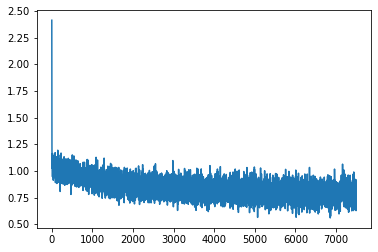

In [99]:
plot(loss_plot)

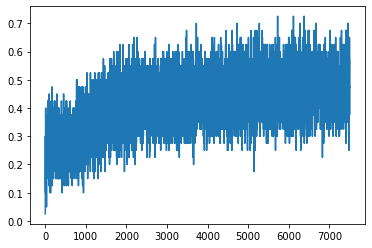

In [100]:
plot(c0_plot)

In [ ]:
#### 此外，根据塞制规则，还可以复用在ImageNet上预训练好的模型如resnet18/34/50等等。

In [ ]:
# 以resnet50为例--nn.Linear的参数需要从512修改为2048
class SVHN_Model2(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()

        model_conv = models.resnet50(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])
        self.cnn = model_conv

        self.fc1 = nn.Linear(2048, 11)
        self.fc2 = nn.Linear(2048, 11)
        self.fc3 = nn.Linear(2048, 11)
        self.fc4 = nn.Linear(2048, 11)
        self.fc5 = nn.Linear(2048, 11)

    def forward(self, img):        
        feat = self.cnn(img)
        # print(feat.shape)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c1, c2, c3, c4, c5